In [1]:
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import collections 
import numpy as np 

In [2]:
#import data from file
path = "../data/loc-brightkite_edges.txt.gz"
G = nx.read_edgelist(path, create_using=nx.Graph(), nodetype=int)
len(G.nodes()), len(G.edges())

(58228, 214078)

# Get largest component

In [3]:
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)
G = G.subgraph(largest_cc)

In [4]:

print("Number of edges:", len(nx.edges(G)))
print("Number of nodes", len(nx.nodes(G)))
print("The average clustering coefficient for the network:", nx.average_clustering(G))
#print("The clustering coefficient for nodes", nx.clustering(G))
print("The maximum degree of the network:", max(dict(G.degree()).values()))

Number of edges: 212945
Number of nodes 56739
The average clustering coefficient for the network: 0.17337881358774052
The maximum degree of the network: 1134


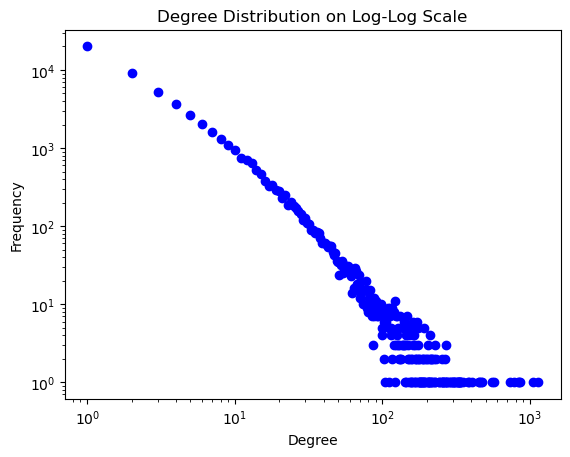

In [5]:
# Calculate the degrees of all nodes and store them in a list
degrees = [degree for node, degree in G.degree()]

# Count the frequency of each degree value
degree_count = Counter(degrees)
degree, frequency = zip(*degree_count.items())

# Create a scatter plot of degrees (log-log scale)
plt.scatter(degree, frequency, c='blue')

# Set the x and y axis to log scale
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution on Log-Log Scale')

# Show the plot
plt.show()

Power law


CCDF log log 


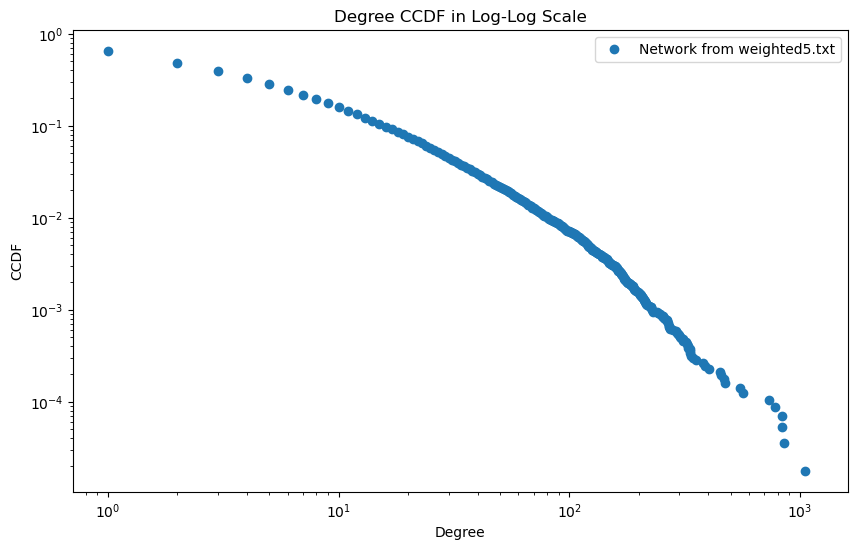

In [6]:
# finding the degree CCDF 
def degree_ccdf(graph):
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    degree, count = zip(*degree_count.items())
    ccdf = 1 - np.cumsum(count[::-1])[::-1]/graph.number_of_nodes()
    return degree, ccdf

# plotting the ccdf for the true graph and the random graph 
degree_G, ccdf_G  = degree_ccdf(G)
plt.figure(figsize=(10, 6))
plt.loglog(degree_G, ccdf_G, marker='o', linestyle='None', label='Network from weighted5.txt')
plt.title('Degree CCDF in Log-Log Scale')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.legend()
plt.show()

Density

Local clustering coefficient

Diameter

Average shortest path

Path length distribution